In [1]:
from nltk.corpus import brown
from collections import defaultdict

# Load Brown corpus with universal tagset
brown_sents = brown.tagged_sents(tagset='universal')

train_size = int(0.9 * len(brown_sents))
brown_train = brown_sents[:train_size]
brown_test = brown_sents[train_size:]

# Find ambiguous words in the training set
word_tag_freq = defaultdict(lambda: defaultdict(int))

for sent in brown_train:
    for word, tag in sent:
        word_tag_freq[word][tag] += 1

ambiguous = {
    w: tags
    for w, tags in word_tag_freq.items()
    if len(tags) > 1
}

In [2]:
# Conceptual MLE for tagging:
# P(tag | prev_tag, word) = count(prev_tag, tag, word) / count(prev_tag, word)

# Problem: unseen bigrams get probability 0
unseen_bigram_prob = 0.0

# Viterbi multiplies probabilities along a path
# One zero factor → entire sentence probability becomes 0
sentence_prob = 0.8 * 0.9 * 0.0 * 0.7  # = 0.0

In [3]:
from nltk import UnigramTagger, BigramTagger
from nltk.tag.hmm import HiddenMarkovModelTrainer

# Model 1: Unigram tagger
unigram_tagger = UnigramTagger(brown_train)

# Model 2: Bigram tagger with backoff to unigram
bigram_tagger = BigramTagger(
    brown_train,
    backoff=unigram_tagger
)

# Model 3: HMM tagger (supervised)
hmm_trainer = HiddenMarkovModelTrainer()
hmm_tagger = hmm_trainer.train(brown_train)

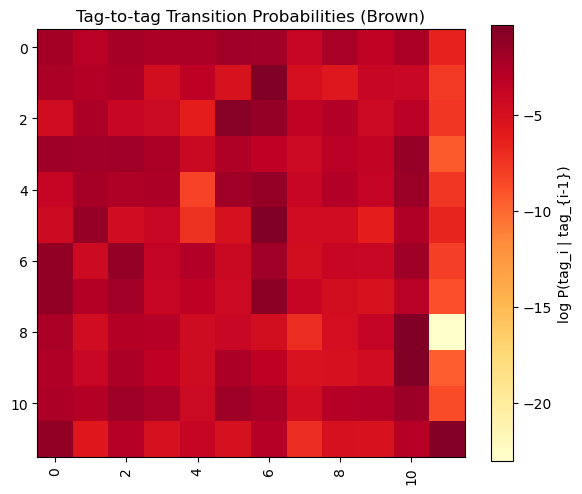

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Collect sequence of tags
all_tags = [tag for sent in brown_train for (_, tag) in sent]

# Build bigram tag sequence (previous tag, current tag)
prev_tags = all_tags[:-1]
curr_tags = all_tags[1:]

# Crosstab: counts of tag bigrams
trans_matrix = pd.crosstab(
    index=prev_tags,
    columns=curr_tags
)

# Normalize rows to get transition probabilities
trans_probs = trans_matrix.div(
    trans_matrix.sum(axis=1),
    axis=0
)

# Visualize (log scale to handle small values)
plt.figure(figsize=(6, 5))
plt.imshow(np.log(trans_probs + 1e-10), cmap="YlOrRd")
plt.colorbar(label="log P(tag_i | tag_{i-1})")
plt.xticks(rotation=90)
plt.title("Tag-to-tag Transition Probabilities (Brown)")
plt.tight_layout()


In [6]:
# 90/10 train-test split on Brown universal
brown_train_size = int(0.9 * len(brown_sents))
brown_train = brown_sents[:brown_train_size]
brown_test = brown_sents[brown_train_size:]

print("Brown Train-Test Split")
print(f"Training set: {len(brown_train):>5d} sentences {sum(len(s) for s in brown_train):>7d} words")
print(f"Test set:     {len(brown_test):>5d} sentences {sum(len(s) for s in brown_test):>7d} words")

# Vocabulary statistics
all_tags = set(tag for sent in brown_train for w, tag in sent)
all_words = set(w for sent in brown_train for w, tag in sent)

print(f"\nNumber of unique tags: {len(all_tags)}")
print(f"Number of unique words: {len(all_words)}")


Brown Train-Test Split
Training set: 51606 sentences 1065750 words
Test set:      5734 sentences   95442 words

Number of unique tags: 12
Number of unique words: 53690


In [7]:
from collections import defaultdict

# 1. TRANSITION COUNTS count(ti-1, ti)
transition_counts = defaultdict(lambda: defaultdict(int))
tag_counts_start = defaultdict(int)  # counts for previous-tag side, incl. START

for sent in brown_train:
    prev_tag = 'START'
    for word, tag in sent:
        transition_counts[prev_tag][tag] += 1
        tag_counts_start[prev_tag] += 1
        prev_tag = tag

# 2. EMISSION COUNTS count(tag, word)
emission_counts = defaultdict(lambda: defaultdict(int))
tag_word_counts = defaultdict(int)

for sent in brown_train:
    for word, tag in sent:
        emission_counts[tag][word] += 1
        tag_word_counts[tag] += 1

# Vocabulary sizes
all_tags = set(tag for sent in brown_train for w, tag in sent)
V_tags = len(all_tags)

all_words = set(w for sent in brown_train for w, tag in sent)
V_words = len(all_words)

print(f"Number of unique tags: {V_tags}")
print(f"Number of unique words: {V_words}")
print()
print("=" * 80)
print("COMPARISON: MLE vs LAPLACE SMOOTHING (Brown universal)")
print("=" * 80)

print("\n--- TRANSITION PROBABILITIES P(tagi | tagi-1) ---")
print(f"{'From Tag':<12} {'To Tag':<12} {'Count':>8} {'MLE':>12} {'Laplace':>12}")
print("-" * 60)

print("\n--- EMISSION PROBABILITIES P(word | tag) ---")
print(f"{'Tag':<10} {'Word':<15} {'Count':>8} {'MLE':>12} {'Laplace':>12}")
print("-" * 60)

# LAPLACE SMOOTHING FORMULAS
# Transition: P_Laplace(ti | ti-1) = (count(ti-1, ti) + 1) / (count(ti-1) + V_tags)
# Emission: P_Laplace(w | t) = (count(w, t) + 1) / (count(t) + V_words)

samples_trans = [
    ('START', 'DET'),
    ('DET', 'NOUN'),
    ('ADJ', 'NOUN'),
    ('NOUN', 'VERB'),]

for from_tag, to_tag in samples_trans:
    count = transition_counts[from_tag][to_tag]
    total = tag_counts_start[from_tag]
    
    mle_prob = count / total if total > 0 else 0.0
    laplace_prob = (count + 1) / (total + V_tags) if total > 0 else 1.0 / V_tags
    
    print(f"{from_tag:<12} {to_tag:<12} {count:>8} {mle_prob:>12.6f} {laplace_prob:>12.6f}")


samples_emit = [
    ('DET', 'the'),
    ('NOUN', 'dog'),
    ('VERB', 'said'),
    ('DET', 'unseenword'),]  # artificially unseen word for demo

for tag, word in samples_emit:
    count = emission_counts[tag].get(word, 0)
    total = tag_word_counts[tag]
    
    mle_prob = count / total if total > 0 else 0.0
    laplace_prob = (count + 1) / (total + V_words)
    
    marker = " [UNSEEN]" if count == 0 else ""
    print(f"{tag:<10} {word:<15} {count:>8} {mle_prob:>12.6f} {laplace_prob:>12.6f}{marker}")

Number of unique tags: 12
Number of unique words: 53690

COMPARISON: MLE vs LAPLACE SMOOTHING (Brown universal)

--- TRANSITION PROBABILITIES P(tagi | tagi-1) ---
From Tag     To Tag          Count          MLE      Laplace
------------------------------------------------------------
START        DET             11544     0.223695     0.223662
DET          NOUN            79217     0.624306     0.624255
ADJ          NOUN            51616     0.660068     0.659980
NOUN         VERB            40741     0.158551     0.158548

--- EMISSION PROBABILITIES P(word | tag) ---
Tag        Word               Count          MLE      Laplace
------------------------------------------------------------
DET        the                58824     0.463524     0.325727
NOUN       dog                   60     0.000233     0.000196
VERB       said                1510     0.009106     0.006883
DET        unseenword             0     0.000000     0.000006 [UNSEEN]

KEY INSIGHT: Laplace adds 1 and V, so unseen

In [8]:
from nltk.tag import UnigramTagger, BigramTagger

# Model 1: Unigram tagger
unigram_tagger = UnigramTagger(brown_train)

# Model 2: Bigram tagger with backoff to unigram
bigram_tagger = BigramTagger(
    brown_train,
    backoff=unigram_tagger
)

# Model 3: HMM tagger (supervised)
from nltk.tag.hmm import HiddenMarkovModelTrainer
hmm_trainer = HiddenMarkovModelTrainer()
hmm_tagger = hmm_trainer.train(brown_train)


In [22]:
def viterbi_with_laplace(sentence_tokens,transition_counts,emission_counts,tag_counts_start,
                         tag_word_counts,all_tags,V_tags,V_words,):
    n = len(sentence_tokens)
    viterbi = {}      # {pos, tag} → best score
    backptr = {}      # {pos, tag} → best previous tag
    
    # INITIALIZATION: position 0
    for tag in all_tags:
        # P(w0 | tag) with Laplace
        w_count = emission_counts[tag].get(sentence_tokens[0], 0)
        emis = (w_count + 1) / (tag_word_counts[tag] + V_words)
        
        # P(tag | START) with Laplace
        t_count = transition_counts['START'].get(tag, 0)
        t_total = tag_counts_start['START']
        trans = (t_count + 1) / (t_total + V_tags) if t_total > 0 else 1.0 / V_tags
        
        score = emis * trans
        viterbi[(0, tag)] = score
        backptr[(0, tag)] = None
    
    # RECURSION: positions 1..n-1
    for pos in range(1, n):
        print(f"RECURSION position: {pos}, word: {sentence_tokens[pos]}")
        for tag in all_tags:
            # Emission for current word
            w_count = emission_counts[tag].get(sentence_tokens[pos], 0)
            emis = (w_count + 1) / (tag_word_counts[tag] + V_words)
            
            best_prev = None
            best_score = 0.0
            
            for prev_tag in all_tags:
                if (pos-1, prev_tag) not in viterbi:
                    continue
                
                prev_score = viterbi[(pos-1, prev_tag)]
                
                # Transition from prev_tag to tag
                t_count = transition_counts[prev_tag].get(tag, 0)
                t_total = tag_counts_start[prev_tag]
                trans = (t_count + 1) / (t_total + V_tags) if t_total > 0 else 1.0 / V_tags
                
                score = prev_score * emis * trans
                
                if score > best_score:
                    best_score = score
                    best_prev = prev_tag
            
            viterbi[(pos, tag)] = best_score
            backptr[(pos, tag)] = best_prev
    
    # BACKTRACK
    print("\nWith Backtracking: \n")
    last_pos = n - 1
    last_tag = max(all_tags, key=lambda t: viterbi.get((last_pos, t), 0))
    
    tags = [last_tag]
    for pos in range(last_pos, 0, -1):
        prev_tag = backptr[(pos, tags[-1])]
        tags.append(prev_tag)
    
    tags.reverse()
    
    tagged_sentence = list(zip(sentence_tokens, tags))
    
    print(f"{' '.join(f'{w} {t}' for w, t in tagged_sentence)}")
    return tagged_sentence

# Example usage
example_sent = ['The', 'old', 'man', 'the', 'boat']
viterbi_with_laplace(
    example_sent,
    transition_counts,
    emission_counts,
    tag_counts_start,
    tag_word_counts,
    all_tags,
    V_tags,
    V_words,
)

RECURSION position: 1, word: old
RECURSION position: 2, word: man
RECURSION position: 3, word: the
RECURSION position: 4, word: boat

With Backtracking: 

The DET old ADJ man NOUN the DET boat NOUN


[('The', 'DET'),
 ('old', 'ADJ'),
 ('man', 'NOUN'),
 ('the', 'DET'),
 ('boat', 'NOUN')]

In [24]:
# Evaluate all three models
from nltk.metrics import accuracy

print("EVALUATION ON TEST SET")
print("=" * 80)

# Unigram accuracy
unigram_acc = unigram_tagger.accuracy(brown_test)
print(f"Unigram Tagger Accuracy:        {unigram_acc:.4f} ({unigram_acc*100:.2f}%)")

# Bigram accuracy
bigram_acc = bigram_tagger.accuracy(brown_test)
print(f"Bigram Tagger Accuracy:         {bigram_acc:.4f} ({bigram_acc*100:.2f}%)")

# HMM accuracy
hmm_acc = hmm_tagger.accuracy(brown_test)
print(f"HMM Tagger Accuracy:            {hmm_acc:.4f} ({hmm_acc*100:.2f}%)")

EVALUATION ON TEST SET
Unigram Tagger Accuracy:        0.9156 (91.56%)
Bigram Tagger Accuracy:         0.9246 (92.46%)
HMM Tagger Accuracy:            0.7011 (70.11%)


In [28]:
import nltk
from nltk.corpus import brown
from nltk import pos_tag
from nltk.tag import map_tag

brown_sents = brown.tagged_sents(tagset='universal')
train_size = int(0.9 * len(brown_sents))
brown_train = brown_sents[:train_size]
brown_test = brown_sents[train_size:]

def treebank_tag_universal(words):
    # pos_tag uses a pre-trained Treebank-style tagger
    ptb_tags = pos_tag(words)
    universal = [
        (w, map_tag('en-ptb', 'universal', t)) 
        for (w, t) in ptb_tags
    ]
    return universal

def treebank_accuracy(test_sents):
    correct, total = 0, 0
    for sent in test_sents:
        words = [w for (w, gold) in sent]
        gold_tags = [gold for (w, gold) in sent]
        pred_tags = [t for (w, t) in treebank_tag_universal(words)]
        correct += sum(p == g for p, g in zip(pred_tags, gold_tags))
        total += len(gold_tags)
    return correct / total

tb_acc = treebank_accuracy(brown_test)
print(f"Treebank (pos_tag) Accuracy: {tb_acc:.4f} ({tb_acc*100:.2f}%)")


Treebank (pos_tag) Accuracy: 0.9022 (90.22%)


In [26]:
# Test your custom viterbi_with_laplace function
test_sentences = [
    ['The', 'old', 'man', 'the', 'boat'],
    ['Time', 'flies', 'like', 'an', 'arrow'],
    ['The', 'dog', 'ran', 'quickly', 'in', 'the', 'park']
]

for sent in test_sentences:
    result = viterbi_with_laplace(sent, transition_counts, emission_counts, 
                                  tag_counts_start, tag_word_counts, 
                                  all_tags, V_tags, V_words)
    print(f"Input: {' '.join(sent)}")
    print(f"Tagged: {' '.join(f'{w}/{t}' for w, t in result)}")
    print()


RECURSION position: 1, word: old
RECURSION position: 2, word: man
RECURSION position: 3, word: the
RECURSION position: 4, word: boat

With Backtracking: 

The DET old ADJ man NOUN the DET boat NOUN
Input: The old man the boat
Tagged: The/DET old/ADJ man/NOUN the/DET boat/NOUN

RECURSION position: 1, word: flies
RECURSION position: 2, word: like
RECURSION position: 3, word: an
RECURSION position: 4, word: arrow

With Backtracking: 

Time NOUN flies NOUN like ADP an DET arrow NOUN
Input: Time flies like an arrow
Tagged: Time/NOUN flies/NOUN like/ADP an/DET arrow/NOUN

RECURSION position: 1, word: dog
RECURSION position: 2, word: ran
RECURSION position: 3, word: quickly
RECURSION position: 4, word: in
RECURSION position: 5, word: the
RECURSION position: 6, word: park

With Backtracking: 

The DET dog NOUN ran VERB quickly ADV in ADP the DET park NOUN
Input: The dog ran quickly in the park
Tagged: The/DET dog/NOUN ran/VERB quickly/ADV in/ADP the/DET park/NOUN



In [29]:
import pandas as pd

results = {
    'Model': ['Unigram', 'Bigram', 'HMM (Brown)', 'TreebankWordPOS'],
    'Accuracy': [0.9156, 0.9246, 0.7011, tb_acc],
    'Speed': ['Fast', 'Medium', 'Slow (DP)', 'Fast (Pre-trained)'],
    'Context': ['No', 'Yes (backoff)', 'Yes (full)', 'Complex rules']
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


          Model  Accuracy              Speed       Context
        Unigram  0.915600               Fast            No
         Bigram  0.924600             Medium Yes (backoff)
    HMM (Brown)  0.701100          Slow (DP)    Yes (full)
TreebankWordPOS  0.902244 Fast (Pre-trained) Complex rules


FINAL MODEL COMPARISON ON BROWN TEST SET
                 Model  Accuracy              Speed       Context          Data dependency
               Unigram    0.9156               Fast            No               Brown only
                Bigram    0.9246             Medium Yes (backoff)               Brown only
           HMM (Brown)    0.7011          Slow (DP)    Yes (full)               Brown only
Treebank (Pre-trained)    0.9022 Fast (Pre-trained) Complex rules Penn Treebank (millions)



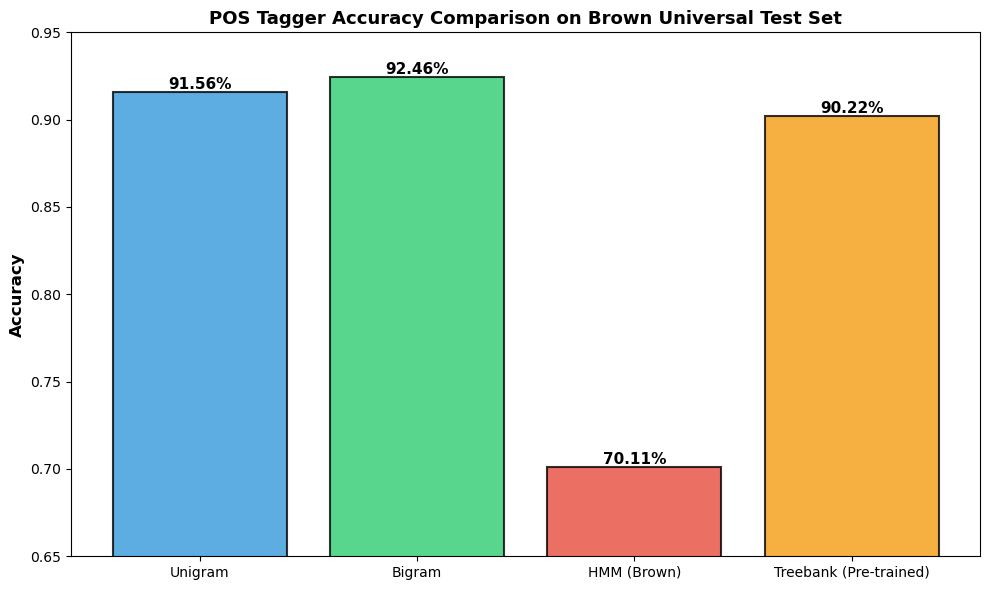


KEY INSIGHTS:
----------------------------------------------------------------------------------------------------
1. Bigram > Unigram: Context helps when bigram counts are reliable
2. HMM << Bigram: Generative model + sparse data + simple smoothing → path collapse
3. Treebank ≈ Bigram: Pre-trained + richer data ≈ simple backoff model
4. Bigram is the 'sweet spot': simple, fast, uses context, competitive accuracy


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Compile results
results = {
    'Model': [
        'Unigram',
        'Bigram',
        'HMM (Brown)',
        'Treebank (Pre-trained)'
    ],
    'Accuracy': [
        0.9156,
        0.9246,
        0.7011,
        0.9022
    ],
    'Speed': [
        'Fast',
        'Medium',
        'Slow (DP)',
        'Fast (Pre-trained)'
    ],
    'Context': [
        'No',
        'Yes (backoff)',
        'Yes (full)',
        'Complex rules'
    ],
    'Data dependency': [
        'Brown only',
        'Brown only',
        'Brown only',
        'Penn Treebank (millions)'
    ]
}

results_df = pd.DataFrame(results)

print("=" * 100)
print("FINAL MODEL COMPARISON ON BROWN TEST SET")
print("=" * 100)
print(results_df.to_string(index=False))
print()

# Accuracy bar chart
fig, ax = plt.subplots(figsize=(10, 6))
models = results_df['Model']
accuracies = results_df['Accuracy']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('POS Tagger Accuracy Comparison on Brown Universal Test Set', 
             fontsize=13, fontweight='bold')
ax.set_ylim([0.65, 0.95])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHTS:")
print("-" * 100)
print("1. Bigram > Unigram: Context helps when bigram counts are reliable")
print("2. HMM << Bigram: Generative model + sparse data + simple smoothing → path collapse")
print("3. Treebank ≈ Bigram: Pre-trained + richer data ≈ simple backoff model")
print("4. Bigram is the 'sweet spot': simple, fast, uses context, competitive accuracy")


In [36]:
import numpy as np
from collections import defaultdict

def viterbi_init_detailed(sentence, transition_counts, emission_counts,
                          tag_counts_start, tag_word_counts,
                          all_tags, V_tags, V_words, laplace=True):
    viterbi = {}
    backptr = {}
    word_0 = sentence[0]
    scores_list = []
    
    for tag in sorted(all_tags):
        # Emission probability
        w_count = emission_counts[tag].get(word_0, 0)
        if laplace:
            emission_prob = (w_count + 1) / (tag_word_counts[tag] + V_words)
        else:
            emission_prob = w_count / tag_word_counts[tag] if tag_word_counts[tag] > 0 else 0
        
        # Transition from START
        t_count = transition_counts['START'].get(tag, 0)
        t_total = tag_counts_start['START']
        if laplace:
            transition_prob = (t_count + 1) / (t_total + V_tags)
        else:
            transition_prob = t_count / t_total if t_total > 0 else 0
        
        # Combined score
        score = emission_prob * transition_prob
        log_score = np.log(score) if score > 0 else float('-inf')
        
        viterbi[(0, tag)] = score
        backptr[(0, tag)] = None
        
        print(f"{tag:<10} {emission_prob:<18.6f} {transition_prob:<18.6f} {score:<18.9f} {log_score:<12.4f}")
        scores_list.append((tag, score))
    
    print()
    print("-"*90)
    best_tag = max(scores_list, key=lambda x: x[1])
    print(f"BEST INITIAL TAG: {best_tag[0]} with score {best_tag[1]:.9f}")
    print("="*90)
    print()
    
    return viterbi, backptr

sentence = ['The', 'old', 'man']

viterbi_init, backptr_init = viterbi_init_detailed(
    sentence, 
    transition_counts,      # from your training code
    emission_counts,        # from your training code
    tag_counts_start,       # from your training code
    tag_word_counts,        # from your training code
    all_tags,              # from your training code
    V_tags,                # 12
    V_words                # 53690
)


VITERBI INITIALIZATION: Position 0, Word = 'The'

Tag        P(word|tag)        P(tag|START)       Product            Log Score   
------------------------------------------------------------------------------------------
.          0.000005           0.076969           0.000000414        -14.6965    
ADJ        0.000008           0.036286           0.000000275        -15.1063    
ADP        0.000005           0.128870           0.000000682        -14.1975    
ADV        0.000010           0.091577           0.000000876        -13.9482    
CONJ       0.000011           0.048123           0.000000544        -14.4249    
DET        0.038246           0.223662           0.008554095        -4.7613     
NOUN       0.000003           0.145124           0.000000466        -14.5795    
NUM        0.000015           0.018056           0.000000265        -15.1427    
PRON       0.000010           0.149463           0.000001562        -13.3694    
PRT        0.000012           0.035433           

In [43]:
def viterbi_recursion_detailed(sentence, transition_counts, emission_counts,
                                tag_counts_start, tag_word_counts,
                                all_tags, V_tags, V_words, viterbi, backptr):
    """Viterbi recursion with detailed step-by-step output."""
    
    n = len(sentence)
    
    print("\n" + "="*100)
    print("VITERBI RECURSION: Filling DP Table")
    print("="*100 + "\n")
    
    for pos in range(1, n):
        word = sentence[pos]
        print(f"{'─'*100}")
        print(f"POSITION {pos}: word = '{word}'")
        print(f"{'─'*100}")
        print(f"{'Current Tag':<12} {'Best Prev':<12} {'Prev Score':<18} {'Trans P':<15} {'Emis P':<15} {'Total':<18}")
        print(f"{'-'*100}")
        
        for tag in sorted(all_tags):
            # Emission for current word
            w_count = emission_counts[tag].get(word, 0)
            emission_prob = (w_count + 1) / (tag_word_counts[tag] + V_words)
            
            best_prev = None
            best_score = 0.0
            
            for prev_tag in sorted(all_tags):
                if (pos-1, prev_tag) not in viterbi:
                    continue
                
                prev_score = viterbi[(pos-1, prev_tag)]
                
                # Transition probability
                t_count = transition_counts[prev_tag].get(tag, 0)
                t_total = tag_counts_start[prev_tag]
                transition_prob = (t_count + 1) / (t_total + V_tags)
                
                total_score = prev_score * transition_prob * emission_prob
                
                if total_score > best_score:
                    best_score = total_score
                    best_prev = prev_tag
            
            viterbi[(pos, tag)] = best_score
            backptr[(pos, tag)] = best_prev
            
            # Only print tags with non-negligible scores
            if best_score > 1e-12 and best_prev:
                prev_s = viterbi[(pos-1, best_prev)]
                t_c = transition_counts[best_prev].get(tag, 0)
                trans_p = (t_c + 1) / (tag_counts_start[best_prev] + V_tags)
                print(f"{tag:<12} {best_prev:<12} {prev_s:<18.9f} {trans_p:<15.6f} {emission_prob:<15.6f} {best_score:<18.12f}")
        
        print()
    
    return viterbi, backptr

viterbi_init, backptr_init = viterbi_recursion_detailed(
    sentence,
    transition_counts,
    emission_counts,
    tag_counts_start,
    tag_word_counts,
    all_tags,
    V_tags,
    V_words,
    viterbi_init,      # pass the result from initialization
    backptr_init
)



VITERBI RECURSION: Filling DP Table

────────────────────────────────────────────────────────────────────────────────────────────────────
POSITION 1: word = 'old'
────────────────────────────────────────────────────────────────────────────────────────────────────
Current Tag  Best Prev    Prev Score         Trans P         Emis P          Total             
----------------------------------------------------------------------------------------------------
.            DET          0.008554095        0.012648        0.000005        0.000000000582    
ADJ          DET          0.008554095        0.241198        0.003631        0.000007491617    
ADP          DET          0.008554095        0.009283        0.000005        0.000000000421    
ADV          DET          0.008554095        0.017644        0.000010        0.000000001443    
CONJ         DET          0.008554095        0.000630        0.000011        0.000000000061    
DET          DET          0.008554095        0.006044     

In [40]:
def viterbi_backtrack_detailed(sentence, viterbi, backptr, all_tags):
    """Backtrack with detailed trace showing each step."""
    
    n = len(sentence)
    last_pos = n - 1

    final_scores = []
    for tag in sorted(all_tags):
        score = viterbi.get((last_pos, tag), 0)
        final_scores.append((tag, score))
        if score > 1e-12:
            print(f"{tag:<10} {score:<20.15f}")
    
    last_tag = max(final_scores, key=lambda x: x[1])[0]
    print()
    print(f"Best final tag: {last_tag}\n")

    tags = [last_tag]
    current_tag = last_tag
    
    for pos in range(last_pos, 0, -1):
        prev_tag = backptr[(pos, current_tag)]
        tags.append(prev_tag)
        arrow = "←"
        print(f"  Position {pos}: {current_tag} {arrow} {prev_tag}")
        current_tag = prev_tag
    
    tags.reverse()
    
    for i, (word, tag) in enumerate(zip(sentence, tags)):
        print(f"  [{i}] {word:15} → {tag}")
    
    return list(zip(sentence, tags))

# =====================================================================
# CALL THE FUNCTION
# =====================================================================

tagged_result = viterbi_backtrack_detailed(
    sentence,
    viterbi_init,      # from recursion step
    backptr_init,      # from recursion step
    all_tags
)

print(f"\nTagged sentence: {tagged_result}")



VITERBI BACKTRACKING

STEP 1: Find best final state (position 2)
------------------------------------------------------------------------------------------
Tag        Score               
------------------------------------------------------------------------------------------
.          0.000000000003852   
ADJ        0.000000000003233   
ADP        0.000000000003488   
CONJ       0.000000000003139   
NOUN       0.000000016298228   
PRT        0.000000000001768   
VERB       0.000000000002417   

Best final tag: NOUN

STEP 2: Follow backpointers backward
------------------------------------------------------------------------------------------
  Position 2: NOUN ← ADJ
  Position 1: ADJ ← DET

STEP 3: Final tagged sequence

  [0] The             → DET
  [1] old             → ADJ
  [2] man             → NOUN

Final Result: The/DET old/ADJ man/NOUN


Tagged sentence: [('The', 'DET'), ('old', 'ADJ'), ('man', 'NOUN')]
